In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nbformat
import re
import ast

def extract_trials_with_f1(nb_path, study_names=None):
    def extract_params_from_line(line):
        match = re.search(r"\{(.+?)\}", line)
        if not match:
            return {}
        try:
            return ast.literal_eval("{" + match.group(1) + "}")
        except:
            return {}

    def parse_trial_line_with_number(line):
        match = re.match(r"Trial (\d+) with params: (.+)", line)
        if not match:
            return None
        trial_number = int(match.group(1))
        try:
            params = ast.literal_eval(match.group(2))
            params["trial_number"] = trial_number
            return params
        except:
            return None

    def extract_f1_with_params(line):
        m = re.search(r"Trial (\d+) finished with value: ([0-9.]+)", line)
        if not m:
            return None
        f1 = float(m.group(2))
        params = extract_params_from_line(line)
        return {"f1_score": f1, **params}

    def split_into_blocks(lines, start_indicator):
        blocks = []
        current_block = []
        for line in lines:
            if start_indicator in line and current_block:
                blocks.append(current_block)
                current_block = []
            current_block.append(line)
        if current_block:
            blocks.append(current_block)
        return blocks

    with open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    trial_param_lines = []
    trial_f1_lines = []
    for cell in nb.cells:
        if cell.cell_type == "code" and "outputs" in cell:
            for output in cell["outputs"]:
                if output.output_type == "stream":
                    for line in output["text"].split("\n"):
                        if re.match(r"Trial \d+ with params:", line):
                            trial_param_lines.append(line.strip())
                        elif re.search(r"Trial \d+ finished with value: [0-9.]+", line):
                            trial_f1_lines.append(line.strip())


    all_trial_params = [parse_trial_line_with_number(line) for line in trial_param_lines]
    all_trial_params = [x for x in all_trial_params if x is not None]

    all_f1_entries = [extract_f1_with_params(line) for line in trial_f1_lines]
    all_f1_entries = [x for x in all_f1_entries if x is not None]


    trial_blocks = split_into_blocks(trial_param_lines, "Trial 0 with params:")
    trial_block_lengths = [len(block) for block in trial_blocks]


    matched_trials_final = []
    trial_index = 0
    for block_idx, block_len in enumerate(trial_block_lengths):
        for i in range(block_len):
            trial = all_trial_params[trial_index]
            trial_index += 1

            matched_f1 = None
            for f1_entry in all_f1_entries:
                if (
                    abs(trial["learning_rate"] - f1_entry.get("learning_rate", -1)) < 1e-10 and
                    trial["weight_decay"] == f1_entry.get("weight_decay") and
                    trial["warmup_steps"] == f1_entry.get("warmup_steps")
                ):
                    matched_f1 = f1_entry["f1_score"]
                    break

            trial["f1_score"] = matched_f1
            if study_names and block_idx < len(study_names):
                trial["study_name"] = study_names[block_idx]
            matched_trials_final.append(trial)

    return pd.DataFrame(matched_trials_final)


In [168]:
df = extract_trials_with_f1(
    "../actual/text_based/trec_coarse_BiLSTM_hp_search.ipynb",
    study_names=["Normální trénink", "Destilace", "Normální trénink - augmentace", "Destilace - augmentace"]
)

In [173]:
top = df[(df["study_name"]== "Normální trénink")].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,f1_score,study_name,lambda_param,temperature
123,0.004483,0.000,3,123,0.869182,Normální trénink,NaN,NaN
122,0.004205,0.000,2,122,0.863613,Normální trénink,NaN,NaN
60,0.004763,0.003,3,60,0.863353,Normální trénink,NaN,NaN
106,0.003617,0.000,4,106,0.861965,Normální trénink,NaN,NaN
115,0.003605,0.000,4,115,0.861813,Normální trénink,NaN,NaN


In [178]:
top = df[(df["study_name"]== "Destilace")&df["lambda_param"] != 0].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,f1_score,study_name,lambda_param,temperature
203,0.004270,0.004,3,53,0.869664,Destilace,0.1,3.0
298,0.004725,0.002,3,148,0.868532,Destilace,0.8,3.5
214,0.003794,0.002,2,64,0.866704,Destilace,1.0,3.5
285,0.003994,0.003,1,135,0.865990,Destilace,0.1,3.5
192,0.004421,0.001,2,42,0.865314,Destilace,0.2,5.0


In [ ]:
top = df[(df["study_name"]== "Normální trénink - augmentace")].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,f1_score,study_name,lambda_param,temperature
361,0.004589,0.010,22,61,0.888727,Normální trénink - augmentace,NaN,NaN
328,0.003740,0.005,10,28,0.877914,Normální trénink - augmentace,NaN,NaN
409,0.004428,0.004,10,109,0.877678,Normální trénink - augmentace,NaN,NaN
402,0.002876,0.004,12,102,0.877494,Normální trénink - augmentace,NaN,NaN
447,0.003138,0.005,6,147,0.877291,Normální trénink - augmentace,NaN,NaN


In [181]:
top = df[(df["study_name"]== "Destilace - augmentace")].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,f1_score,study_name,lambda_param,temperature
494,0.003791,0.000,16,44,0.896980,Destilace - augmentace,1.0,4.0
558,0.003930,0.004,14,108,0.896909,Destilace - augmentace,1.0,2.5
529,0.004197,0.002,17,79,0.896516,Destilace - augmentace,1.0,3.5
544,0.004303,0.001,19,94,0.895913,Destilace - augmentace,1.0,3.5
553,0.003846,0.002,18,103,0.895748,Destilace - augmentace,1.0,3.5


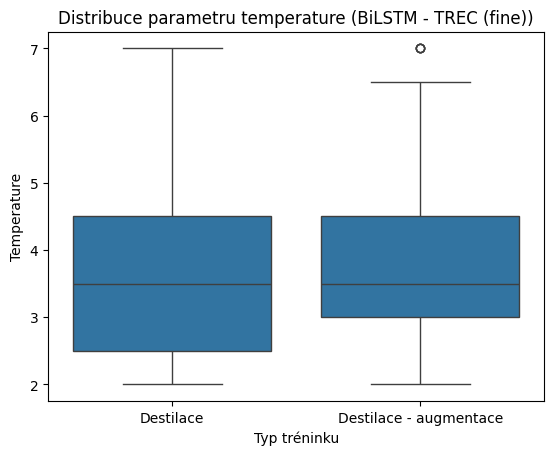

In [ ]:
sns.boxplot(data=df[(df["study_name"].isin(["Destilace", "Destilace - augmentace"]))], x="study_name", y="temperature")
plt.title("Distribuce parametru temperature (BiLSTM - TREC (fine))")
plt.ylabel("Temperature")
plt.xlabel("Typ tréninku")
plt.show()

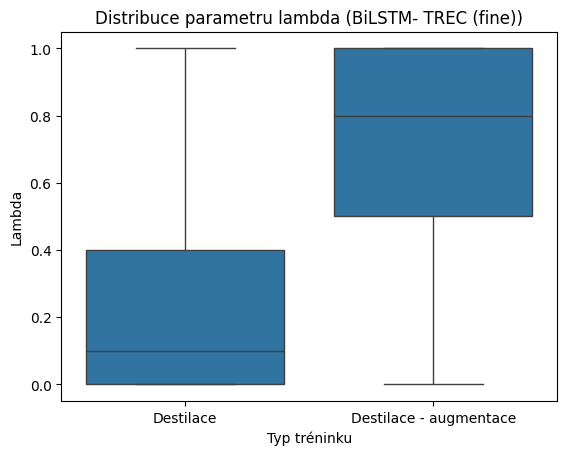

In [ ]:
sns.boxplot(data=df[(df["study_name"].isin(["Destilace", "Destilace - augmentace"]))], x="study_name", y="lambda_param")
plt.title("Distribuce parametru lambda (BiLSTM- TREC (fine))")
plt.ylabel("Lambda")
plt.xlabel("Typ tréninku")
plt.show()